In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from models.utils.common import get_project_root, parse_params

In [2]:
# Load results
experiment_name = "v1_initial_run"
results_dir = os.path.join(get_project_root(), "results", experiment_name)
results = pd.read_csv(os.path.join(results_dir, "optuna_results.csv"))
results.head(1)

,model,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_train_accuracy,mean_train_precision,mean_train_recall,mean_train_f1,overfit,overfit_flg
0,RandomForest,"{'n_estimators': 178, 'max_depth': 24, 'max_fe...",0.861124,0.766128,0.604005,0.675471,0.954179,0.957267,0.846283,0.898337,0.222866,True


In [3]:
# Parse params for readability
# Convert stringified dicts to real dicts
results["params"] = results["params"].apply(parse_params)
# Parse params for readability 
params_df = pd.json_normalize(results["params"])
results = pd.concat([results.drop(columns="params"), params_df], axis=1)
results

,model,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_train_accuracy,mean_train_precision,mean_train_recall,mean_train_f1,overfit,overfit_flg,n_estimators,max_depth,max_features,max_samples,learning_rate,subsample,gamma
0,RandomForest,0.861124,0.766128,0.604005,0.675471,0.954179,0.957267,0.846283,0.898337,0.222866,True,178.0,24,sqrt,0.666353,NaN,NaN,NaN
1,RandomForest,0.861124,0.766128,0.604005,0.675471,0.954179,0.957267,0.846283,0.898337,0.222866,True,60.0,26,sqrt,0.894368,NaN,NaN,NaN
2,RandomForest,0.861124,0.766128,0.604005,0.675471,0.954179,0.957267,0.846283,0.898337,0.222866,True,66.0,30,sqrt,0.813502,NaN,NaN,NaN
3,RandomForest,0.861124,0.766128,0.604005,0.675471,0.954179,0.957267,0.846283,0.898337,0.222866,True,86.0,22,log2,0.888586,NaN,NaN,NaN
4,RandomForest,0.861124,0.766128,0.604005,0.675471,0.954179,0.957267,0.846283,0.898337,0.222866,True,175.0,25,log2,0.670690,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,XGBoost,0.871955,0.775850,0.653804,0.709615,0.898479,0.837081,0.714855,0.771133,0.061518,True,NaN,8,NaN,NaN,0.118381,0.616608,0.0
146,XGBoost,0.873715,0.782571,0.653975,0.712512,0.891272,0.824098,0.693677,0.753262,0.040749,False,NaN,6,NaN,NaN,0.161767,0.832299,0.0
147,XGBoost,0.871402,0.772657,0.655430,0.709231,0.905440,0.850876,0.733379,0.787734,0.078503,True,NaN,8,NaN,NaN,0.153190,0.812941,0.0
148,XGBoost,0.872917,0.779437,0.653975,0.711214,0.889409,0.819024,0.690340,0.749180,0.037966,False,NaN,6,NaN,NaN,0.143897,0.636320,0.0


In [4]:
# Filter out overfitted trials s
non_overfitted = results[
    (results["overfit"] < 0.05)
    & (
        results["model"] != "RandomForest"
    )  # Exclude RandomForest due to consistent overfitting (not generalizing well)
    & (
        results["mean_test_precision"] > 0.78
    )  # Marketing: minimize false positives
].copy()
print(f"\nNumber of non-overfitted trials: {len(non_overfitted)}")

print(non_overfitted["model"].value_counts())

# Calculate robust F1
non_overfitted["robust_f1"] = (
    non_overfitted["mean_test_f1"] - 0.3 * non_overfitted["overfit"]
)



Number of non-overfitted trials: 68
model
XGBoost             39
GradientBoosting    29
Name: count, dtype: int64


In [ ]:
# Build summary table
summary_cols = [
    "model",
    "mean_test_f1",
    "mean_test_accuracy",
    "mean_test_precision",
    "mean_test_recall",
    "overfit",
    "params",
]

non_overfitted.groupby("model")[summary_cols].describe().T

In [5]:
# Top 3 per model by robust F1
top_models = []
for model in non_overfitted["model"].unique():
    model_top = non_overfitted[non_overfitted["model"] == model].nlargest(
        3, "robust_f1"
    )
    top_models.append(model_top)
top_models = pd.concat(top_models).reset_index(drop=True)

In [6]:
top_models

,model,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_train_accuracy,mean_train_precision,mean_train_recall,mean_train_f1,overfit,overfit_flg,n_estimators,max_depth,max_features,max_samples,learning_rate,subsample,gamma,robust_f1
0,GradientBoosting,0.874411,0.788918,0.648670,0.711946,0.882622,0.808363,0.667751,0.731348,0.019403,False,116.0,4,NaN,NaN,0.142102,0.992667,NaN,0.706125
1,GradientBoosting,0.873183,0.783600,0.649269,0.710131,0.883850,0.810245,0.671944,0.734635,0.024504,False,187.0,4,NaN,NaN,0.096747,0.695267,NaN,0.702780
2,GradientBoosting,0.873654,0.782152,0.654146,0.712438,0.888272,0.817679,0.686019,0.746068,0.033630,False,155.0,5,NaN,NaN,0.087115,0.748633,NaN,0.702350
3,XGBoost,0.874248,0.784365,0.654317,0.713459,0.882693,0.805991,0.671345,0.732526,0.019066,False,NaN,5,NaN,NaN,0.183085,0.708254,3.0,0.707740
4,XGBoost,0.873818,0.786073,0.649355,0.711195,0.879315,0.800794,0.659750,0.723455,0.012260,False,NaN,3,NaN,NaN,0.293218,0.720824,2.0,0.707517
5,XGBoost,0.873613,0.784495,0.650552,0.711268,0.879612,0.799268,0.663558,0.725074,0.013806,False,NaN,4,NaN,NaN,0.170390,0.604943,3.0,0.707126


In [8]:
plt.rcParams["figure.figsize"] = (10, 6)

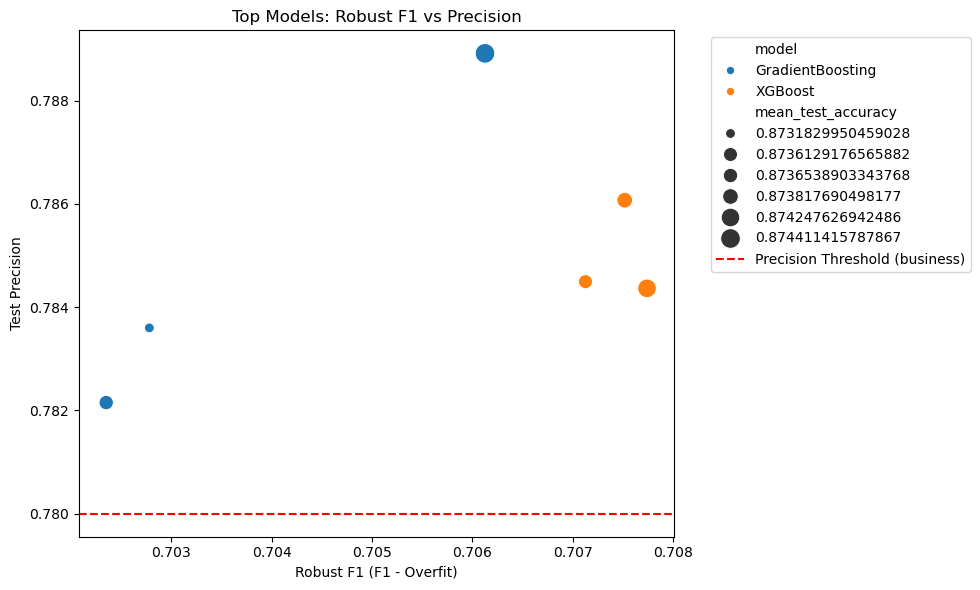

In [9]:
# Scatterplot: Robust F1 vs Precision

sns.scatterplot(
    data=top_models,
    x="robust_f1",
    y="mean_test_precision",
    hue="model",
    size="mean_test_accuracy",
    sizes=(50, 200),
)
plt.axhline(0.78, color="red", linestyle="--", label="Precision Threshold (business)")
plt.xlabel("Robust F1 (F1 - Overfit)")
plt.ylabel("Test Precision")
plt.title("Top Models: Robust F1 vs Precision")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Model Selection
- Non-overfitted trials: {len(non_overfitted)} (GradientBoosting/XGBoost, precision > 0.8).
- Top models: {len(top_models)} (3 per model by robust F1).
- Selected for refinement: 3 (2 XGBoost, 1 GradientBoosting).
- Criteria: High robust F1, precision > 0.8 for marketing.
- Recommendation: XGBoost leads; GradientBoosting competitive, included for refinement.
- Next: Hyperparameter analysis in `hyperparameter_analysis.ipynb`.

In [11]:
# Select top models for refinement
selected_models = pd.concat(
    [
        top_models[top_models["model"] == "XGBoost"].nlargest(2, "robust_f1"),
        top_models[top_models["model"] == "GradientBoosting"].nlargest(1, "robust_f1"),
    ]
).reset_index(drop=True)
selected_models

,model,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_train_accuracy,mean_train_precision,mean_train_recall,mean_train_f1,overfit,overfit_flg,n_estimators,max_depth,max_features,max_samples,learning_rate,subsample,gamma,robust_f1
0,XGBoost,0.874248,0.784365,0.654317,0.713459,0.882693,0.805991,0.671345,0.732526,0.019066,False,NaN,5,NaN,NaN,0.183085,0.708254,3.0,0.707740
1,XGBoost,0.873818,0.786073,0.649355,0.711195,0.879315,0.800794,0.659750,0.723455,0.012260,False,NaN,3,NaN,NaN,0.293218,0.720824,2.0,0.707517
2,GradientBoosting,0.874411,0.788918,0.648670,0.711946,0.882622,0.808363,0.667751,0.731348,0.019403,False,116.0,4,NaN,NaN,0.142102,0.992667,NaN,0.706125


In [ ]:
# Save results
selected_models.to_csv(os.path.join(results_dir, "selected_models.csv"), index=False)